In [1]:
import snntorch as snn
from snntorch import utils
from snntorch import spikegen
from snntorch import spikeplot as splt
from snntorch import functional as SF


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML


In [3]:
# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)


# Network Architecture: 100 - 200 - 4
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 


# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Input: Latency_spike X[t] and U[t-1], Neuron output: Spike S[t] and U[t]  
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=0.2)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.2)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the finial laye
        spk2_rec = []
        mem2_rec = []
        
        spike_data = spikegen.latency(x, num_steps=num_steps, threshold=0.001, clip=True, normalize=True, linear=True) 
        for latency_data in spike_data:
            cur1 = self.fc1(latency_data)          # Spike[t] x weight --> post-synaptic current
            spk1, mem1 = self.lif1(cur1, mem1)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
def test(net, test_loader):
    total = 0
    correct = 0

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            # forward pass
            test_spk, _ = net(data.reshape(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.cpu().sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).cpu().sum().item()
        
        return 100. * float(correct) / float(total)
    
net = Net()
try:
    net.load_state_dict(torch.load('10x10_Latency3.pt'), strict=False)   # strict=False: ignore non-matching keys
    net.eval()
except:
    raise Exception('10x10_Latency3.pt has not been found.')
    
print('Test Set Accuracy: \t%2.2f%%' % test(net, test_loader))

The size of test_set is 4157
Test Set Accuracy: 	96.30%


In [4]:
print(test(net, test_loader))

96.2954053403897


In [9]:
import memtorch
import copy
from memtorch.mn.Module import patch_model
from memtorch.map.Input import naive_scale
from memtorch.map.Parameter import naive_map   # weights within torch.nn.Linear layers to equivalent conductance values

reference_memristor = memtorch.bh.memristor.Stanford_PKU
reference_memristor_params = {'time_series_resolution': 5e-4}
memristor = reference_memristor(**reference_memristor_params) 

net = Net()
net.load_state_dict(torch.load('10x10_Latency3.pt'), strict=False)   # strict=False: ignore non-matching keys
    
patched_model = patch_model(copy.deepcopy(net),
                            memristor_model=reference_memristor,
                            memristor_model_params=reference_memristor_params,
                            module_parameters_to_patch=[torch.nn.Linear],
                            mapping_routine=naive_map,
                            transistor=True,
                            programming_routine=None,
                            max_input_voltage=0.3,
                            scaling_routine=naive_scale,    # Naive method to encode input values as bit-line voltages.
                            ADC_resolution=8,
                            ADC_overflow_rate=0.,
                            quant_method='linear')

Patched Linear(in_features=100, out_features=200, bias=True) -> bh.Linear(in_features=100, out_features=200, bias=True)
Patched Linear(in_features=200, out_features=4, bias=True) -> bh.Linear(in_features=200, out_features=4, bias=True)


In [10]:
patched_model.tune_()  # Method to determine a linear relationship between a memristive crossbar and the output for a given memristive module.

Tuned bh.Linear(in_features=100, out_features=200, bias=True). Coefficient of determination: 0.999777 [856.513550, -0.000006]
Tuned bh.Linear(in_features=200, out_features=4, bias=True). Coefficient of determination: 0.999766 [590.764526, -0.000042]


### The converted and tuned MSNN is benchmarked using the MNIST test data set. 

In [11]:
print(test(patched_model, test_loader))

96.43974019725763


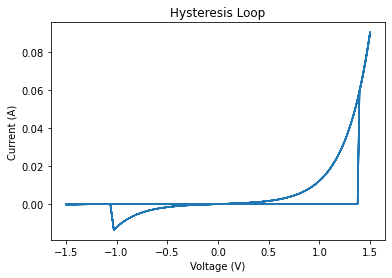

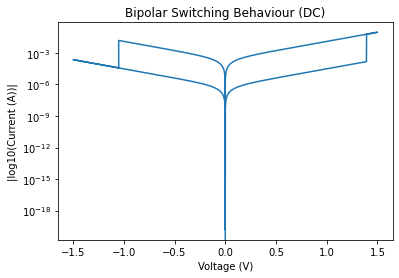

In [12]:
# Reference memristor model

reference_memristor = memtorch.bh.memristor.Stanford_PKU
reference_memristor_params = {'time_series_resolution': 5e-4}
memristor = reference_memristor(**reference_memristor_params)   
memristor.plot_hysteresis_loop()
memristor.plot_bipolar_switching_behaviour()

# **: when define the function, put all keyword arguments into a dictionary for the function to use
#     when call the function, turn the dictionary's key-value pairs into keyword arguments